# IFU Cube Fitting




使用场景

应用方向：AGN（活动星系核）的连续谱和发射线建模；波长范围 1.47-1.87 微米。
数据：NIFS （双子座望远镜上的近红外积分场光谱仪）；观测目标：NGC 4151。
工具：specutils、jdaviz/cubeviz、astropy、matplotlib、bottleneck。
跨仪器兼容性：NIRSpec；潜在适用于 MIRI。
文档：本笔记本是 STScI JWST 后管道数据分析工具生态系统的一部分，可直接从 JDAT Notebook Github 目录 下载。

⸻

简介

本笔记本使用 NGC 4151 活动星系核 的 3D IFU 数据立方示例（Storchi-Bergmann et al. 2009, MNRAS, V 394, pp. 1148-1166）。该数据集是在 双子座天文台（Gemini） 采用 近红外积分场光谱仪（NIFS） 观测的 自适应光学（AO）H 波段（1.47-1.87 µm） 数据集。NIFS 是一种与 JWST NIRSpec 结构相似的 图像切片式 IFU 仪器。

本笔记本执行了一些基础的光谱分析任务：
	•	使用 jdaviz/cubeviz 检查数据集并提取 1D 光谱。
	•	在靠近 1.644 µm 的 [Fe II] 发射线 附近进行 连续谱拟合 并将其扣除。
	•	由于 H I Brackett 12 原子氢发射线（紧邻 [Fe II] 发射线）会对 [Fe II] 流出物产生污染，因此对其进行 拟合并去除。
	•	生成的数据子立方包括：
	•	连续谱模型
	•	扣除连续谱后的 [Fe II] 纯发射线
	•	这些处理后的数据集将作为 后续笔记本分析的起点。

注意：本笔记本的默认分析目标是 1.6440 µm 的 [Fe II] 发射线，但可以调整波长范围，以适用于任何感兴趣的发射线的连续谱拟合与扣除。

⸻

导入相关工具包
	•	time —— 计算代码运行时间
	•	numpy —— 数组处理和数学计算
	•	matplotlib.pyplot —— 绘制图像和光谱
	•	astropy.io —— 读取和写入 FITS 立方数据与图像
	•	astropy.modeling —— 光谱曲线建模
	•	astropy.utils.data —— 访问数据文件
	•	specutils.fitting —— 光谱数据拟合
	•	specutils Spectrum1D —— 用于建模发射线
	•	jdaviz —— 在笔记本中使用 cubeviz 进行 IFU 数据分析

In [1]:
# load important packages
import os
import time
from IPython.display import YouTubeVideo
import warnings

import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.modeling.functional_models import Gaussian1D
from astropy.utils.data import download_file
from specutils import Spectrum1D
from jdaviz import Cubeviz
from specutils.manipulation import extract_region
from specutils.spectra import SpectralRegion
from regions import PixCoord, CirclePixelRegion
from glue.core.roi import XRangeROI

In [2]:
import jdaviz
print(jdaviz.__version__)

4.1.1


In [3]:
# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
# Save and Load Objects Using Pickle (needed to get the parameter file at the end)
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [10]:
crval3

14766.4

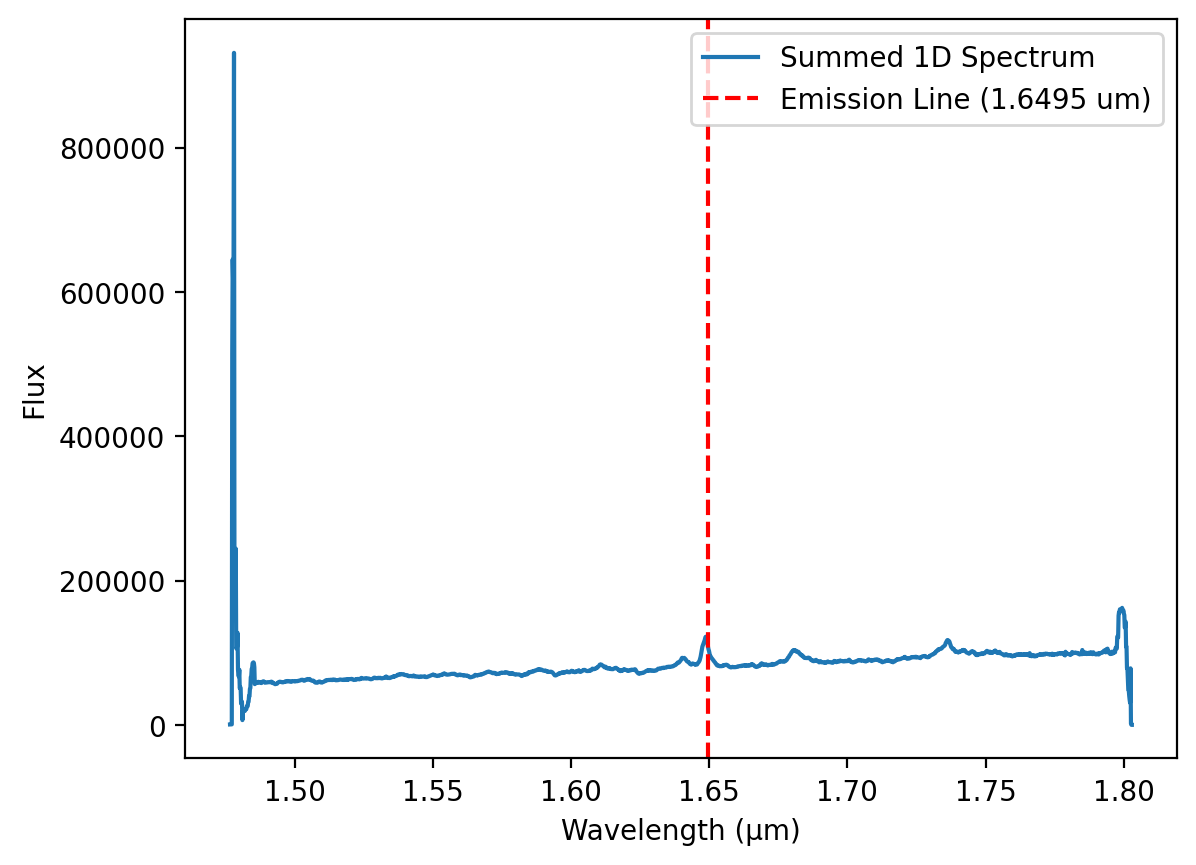

In [11]:
# 该代码单元用于访问 IFU（Integral Field Unit）数据立方（datacube）文件，
# 从 FITS 文件头信息中定义波长网格，并绘制简单的 1 维光谱（即对 IFU 数据进行光谱求和）。

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import download_file

# 读取一个感兴趣的 3D IFU 数据立方文件以及其 FITS 头信息。
# 这里的数据文件是 JWST 观测的 NGC 4151 星系的 H 波段 IFU 立方数据。
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'

# 下载数据文件，并启用缓存以避免重复下载
fn = download_file(cube_file, cache=True)

# 使用 astropy.io.fits 读取 FITS 数据立方体
cube = fits.getdata(fn)  # 获取数据立方体（3D 数据）
header_cube = fits.getheader(fn)  # 获取 FITS 头信息

# 获取数据立方体的维度信息
nz, ny, nx = cube.shape  # nz 代表波长维度的切片数，ny 和 nx 代表空间维度（图像的高度和宽度）

# 从 FITS 头信息中提取波长轴的关键字：
# CDELT3: 每个通道的波长间隔（单位为 Ångström）
# CRVAL3: 波长轴的零点（起始波长，单位为 Ångström）
crdelt3 = header_cube['CDELT3']  # 读取波长步长（通道间隔）
crval3 = header_cube['CRVAL3']  # 读取波长起始值

# 根据 FITS 头信息定义波长网格：
# 使用 numpy.arange 生成从 0 到 nz-1 的整数索引，并计算每个波长通道的实际波长。
# 最后将波长单位从 Ångström 转换为微米（um）。
wave = ((crdelt3 * np.arange(nz)) + crval3) / 10000.0  # 转换单位 Ångström → 微米（1 Å = 0.0001 µm）

# 定义活动星系核（AGN）的红移值
redshift = 0.00332  # NGC 4151 的已知红移

# 选定感兴趣的发射线：
# 这里选择 [Fe II] 1.644 μm（即 1.64400 微米）发射线，
# 并考虑红移效应，即计算观测到的波长
emission_line = 1.64400 * (1 + redshift)  # 计算红移后波长（单位：微米）

# 找到最接近该发射线的波长索引：
# np.abs(wave - emission_line) 计算波长数组中所有元素与发射线波长的差值，
# np.argmin() 找到该差值最小的索引，即最接近该发射线的位置。
emission_line_index = np.abs(wave - emission_line).argmin()

# 计算整个 IFU 数据立方的总光谱：
# 对数据立方体在空间维度（y 和 x）上进行求和，得到 1 维光谱。
flux1 = np.sum(cube, axis=(1, 2))  # 对每个波长通道的所有像素求和，得到总光谱

# 绘制 1 维光谱
plt.figure(0)
plt.plot(wave, flux1, label='Summed 1D Spectrum')  # 绘制波长 vs. 总光谱
plt.axvline(emission_line, color='red', linestyle='--', label=f'Emission Line ({emission_line:.4f} um)')  # 标出发射线位置
plt.xlabel('Wavelength (µm)')  # x 轴标签：波长（微米）
plt.ylabel('Flux')  # y 轴标签：光通量
plt.legend()  # 显示图例
plt.show()  # 显示图像

我们观察到，累加后的 1D 光谱在光谱两端表现出明显的噪声波动（“ratty”）。这一 1D 光谱数据数组超出了仪器的标称可用数据范围。因此，我们将忽略这些质量较差的光谱区域，并专注于活动星系核（AGN）的光通量分析。

我们感兴趣的 [Fe II] 发射特征是一个位于 1.65 微米短波端 的明亮而强烈的发射线。需要注意的是，H I Brackett 12 发射线位于 [Fe II] 线的蓝侧，对其造成一定的污染。

我们可以利用光谱图窗口来读取感兴趣的波长值，以便定义分析所需的光谱范围（可参考光谱图右下角的波长/光通量网格数据）。

特别说明：在此数据集中，[Fe II] 发射线 红侧（长波方向） 的一部分光谱区域提供了一个较为干净的连续谱测量。然而，在 [Fe II] 和 H I Brackett 12 发射线的蓝侧（短波方向），存在其他的发射和吸收特征，使得明确识别连续谱变得非常困难。因此，相比于采用包含整个发射线的更大波长范围，在红侧区域进行简单的线性拟合 会更加准确。

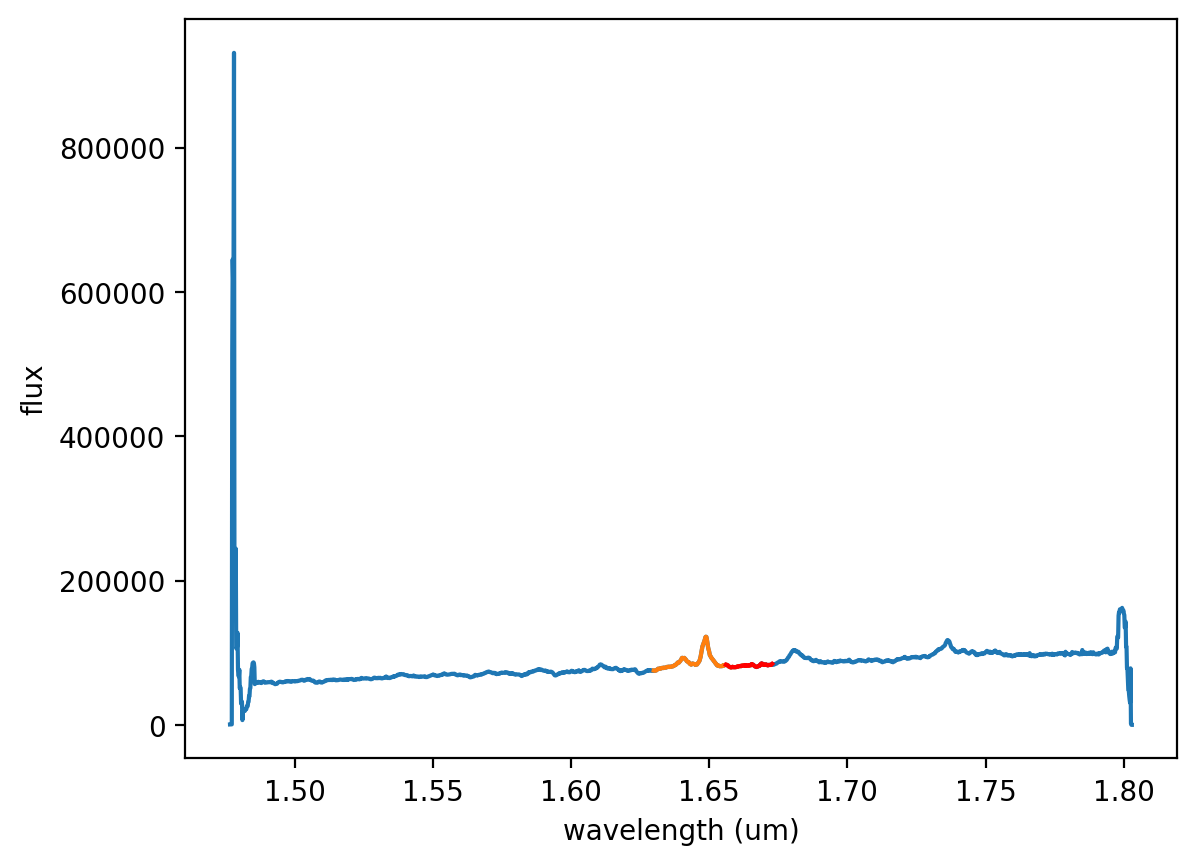

In [12]:
# This cell defines the wavelength regions of interest: around the emission line, and the location
# where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
# Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

# Show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')
plt.xlabel('wavelength (um)')
plt.ylabel('flux')
plt.show()

### Cubeviz Visualization
You can also visualize images inside a Jupyter notebook using [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html)

### Video: 

This Cubeviz Demo is from the official JWST Observer YouTube channel. It shows an example of how to use Cubeviz for a specific science case (not this notebook's science case).

In [ ]:
vid = YouTubeVideo("ayb6OkmZUwU")
display(vid)

In [ ]:
cubeviz = Cubeviz()
cubeviz.show()

In [ ]:
# Here, we load the data into the Cubeviz app.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubeviz.load_data(fn)

A video is shown below illustrating the procedure.  The following steps are applied:

When you load your cube, you will see a collapsed spectrum of all the spaxels in the spectral viewer at the bottom.

If you draw a region (circle or square) in the flux viewer, you will see a collapsed spectrum of that particular region in the spectral viewer, too. For this example, we want to first define a circular region at the central position of the bright AGN flux, which is at approximately the cube center position.<br>
<img src='./cubeviz_select_subset.png' alt="Select a circular subset on the AGN in the center of the image." width="500"/>

Now, use the flux viewer and again use the 'define circular region of interest' icon to make spectra at two positions associated with the outflow emission in [Fe II].  The redshifted outflow is at approximate x position = 12, y position = 36.  This will be 'Subset 2' and will show up in green in the display. The blueshifted outflow is at approximately x position = 48, y position = 24 in pixel index units.  This will be 'Subset 3' and will show up in blue in the display. _Hint: the coordinates of the cursor are reported at the top of the tool_<br>
<img src='./cubeviz_select_subset_outflow.png' alt="Select a circular subset on each side of the AGN to look at the outflow." width="500"/>

## Defining your Spectral Regions

Next, you will want to define the wavelengths of interest in your spectral viewer for both your line and continuum analysis.  To do this, you will similarly click the 'define region of interest' icon in your spectral viewer and drag a box over the wavelengths you desire. The line emission ('Subset 4' ) should span approximately 1.630 - 1.665 um, and the continuum emission ('Subset 5') should span approximately 1.656 - 1.673 um.<br>
<img src='./cubeviz_select_spectral_subset.png' alt="Select a spectral subset on the emission feature and one on the continuum." width="500"/><br>
_Hint: subsets can be modified in the Subset Tools plugin_

### Some Notes:

* If your cell window requires you to scroll to see the different displays in cubeviz, you can toggle the scroll window in the main menu of the notebook: Cell -> Current Outputs -> Toggle Scrolling

* To better visualize the cube, you can change the display options in the Plot Option plugin.

# Extract Subset Spectrum in Cubeviz Spectrum Viewer

Retrieve the spectra of the user-defined regions from the Spectrum Viewer as a Spectrum1D object. First, we create the regions from the API in case the notebook is not run interactively.

In [ ]:
# Create spatial regions
spatial_regions = cubeviz.get_interactive_regions()

if 'Subset 1' not in spatial_regions.keys():
    agn_region = CirclePixelRegion(center=PixCoord(x=29, y=29), radius=6)
    cubeviz.load_regions(agn_region)
if 'Subset 2' not in spatial_regions.keys():
    redshifted_outflow = CirclePixelRegion(center=PixCoord(x=12, y=36), radius=6)
    cubeviz.load_regions(redshifted_outflow)
if 'Subset 3' not in spatial_regions.keys():
    blueshifted_outflow = CirclePixelRegion(center=PixCoord(x=48, y=24), radius=6)
    cubeviz.load_regions(blueshifted_outflow)

spatial_regions = cubeviz.get_interactive_regions()
spatial_regions

By default, the spectra have been extracted with the `sum` function and default options in the spectral extraction plugin. For the purpose of this notebook, we would like to have spectra extracted with the `mean` function instead. We can do that from the interface like in the screenshot here below or running the following cells. <br>
<img src='./cubeviz_spectral_extraction_plugin.png' alt="Open the spectral extraction plugin, select a spatial subset, and the extraction function mean." width="500"/><br>

In [ ]:
spec_ext = cubeviz.plugins['Spectral Extraction']
spec_ext.function = 'Mean'

spec_ext.aperture = 'Subset 1'
spec_ext.add_results = 'Spectrum (Subset 1, mean)'
spec_ext.extract()

spec_ext.aperture = 'Subset 2'
spec_ext.add_results = 'Spectrum (Subset 2, mean)'
spec_ext.extract()

spec_ext.aperture = 'Subset 3'
spec_ext.add_results = 'Spectrum (Subset 3, mean)'
spec_ext.extract()

In [ ]:
# Extract spectra corresponding to the colored regions in cubeviz
spectrum1 = cubeviz.get_data("Spectrum (Subset 1, mean)") # AGN Center
spectrum2 = cubeviz.get_data("Spectrum (Subset 2, mean)") # Red shifted component
spectrum3 = cubeviz.get_data("Spectrum (Subset 3, mean)") # Blue shifted component
spectrum1

In [ ]:
# Extract the line region defined in the spectral viewer
regions = cubeviz.specviz.get_spectral_regions()
        
if "Subset 4" in regions.keys():
    line_region = regions["Subset 4"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)
    sv = cubeviz.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(16300, 16650))

In [ ]:
# Extract the continuum region defined in the spectral viewer
if "Subset 5" in regions.keys():
    continuum_region = regions["Subset 5"]
else:
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)
    sv = cubeviz.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(16560, 16730))

regions = cubeviz.specviz.get_spectral_regions()
regions

In [ ]:
# Apply the spectral region
# (creates new collapsed spectra if user did not in jdaviz)
if not spectrum1:
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_agn = extract_region(tmpspec, line_region)
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    
else: 
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_red = extract_region(tmpspec, line_region)
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)
else:    
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_blue = extract_region(tmpspec, line_region)
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)
else:     
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

In [ ]:
# Visualize new subsets
plt.figure()
plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')
plt.title('Spectrum subset 1')
plt.xlabel('wavelength')
plt.ylabel('flux')

In [ ]:
# Visualize new subsets
plt.figure()
plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')
plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')
plt.title('Spectra subset 2 and 3')
plt.xlabel('wavelength')
plt.ylabel('flux')

## Fit the Continuum at the Spectral Region Location

Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

We will first fit an individual spectrum to test if our fitting parameters are good, then we will switch to fitting the full cube. </br>
**Single spectrum**
Select Data: Spectrum Subset 1 (mean) <br>
Select Spectral Region: Subset 5<br>
Model: Linear1D<br>
ModelID: L<br>
Click "Add component"<br>
Model Parameters: Leave Default<br>
Model Equation Editor: L<br>
Model Label: LinFitCont<br>
Click "Fit model", which fits the collapsed spectrum.<br>
View the fit in the spectral viewer and confirm you are happy with it. <br>

**Full cube**
Toggle "Cube fit" at the top.</br>

Change the name to LinFitCont_cube and click again "Fit model".<br>

<img src='./cubeviz_model_fitting.png' alt="Model fitting can be set up in the plugin." width="700"/>

The fitted cube can be accessed in the data dropdown of the 2D viewers.

### Use the API instead

In [ ]:
models = cubeviz.get_models()

if 'LinFitCont' in models.keys():
    singlemodel = models['LinFitCont']
else:
    # Open model fitting plugin
    plugin_mf = cubeviz.plugins['Model Fitting']
    plugin_mf.open_in_tray()
    # Input the appropriate datasets
    plugin_mf.dataset = 'Spectrum (sum)'
    plugin_mf.spectral_subset = 'Subset 5'
    # Input model component
    plugin_mf.create_model_component(model_component='Linear1D',
                                     model_component_label='L1')
    # Model equation gets populated automatically
    plugin_mf.equation = 'L1'    
    # After we run this, we go to the GUI and check that the fit makes sense
    plugin_mf.add_results.label = 'LinFitCont'
    plugin_mf.cube_fit = False    
    plugin_mf.calculate_fit()

if 'LinFitCont_cube (30, 30)' in models.keys():
    cubemodel = models['LinFitCont_cube']
else:
    # Open model fitting plugin
    plugin_mf = cubeviz.plugins['Model Fitting']
    plugin_mf.open_in_tray()
    # Set the fitting to cube
    plugin_mf.cube_fit = True
    # Input the appropriate datasets
    plugin_mf.dataset = 'contents[SCI]'
    plugin_mf.spectral_subset = 'Subset 5'
    # Input model component
    plugin_mf.create_model_component(model_component='Linear1D',
                                     model_component_label='L2')
    # Model equation gets populated automatically
    plugin_mf.equation = 'L2'    
    # After we run this, we go to the GUI and check that the fit makes sense
    plugin_mf.add_results.label = 'LinFitCont_cube'
    plugin_mf.calculate_fit()

In [ ]:
models = cubeviz.get_models()
#models
models['LinFitCont_cube (30, 30)']

## Pulling other data

Note, in cubeviz, you can either return the collapsed spectra as we did above by using the `function`
keyword argument along with (optionally) a `spatial_subset`, or return the entire data cube by omitting
these keywords as below.

In [ ]:
# List available data
print(cubeviz.data_labels)

# Get full original cube out
scidata = cubeviz.get_data("contents[SCI]")
scidata

In [ ]:
# Extract SCI cube and continuum model from Cubeviz above and make a continuum subtracted cube
if 'LinFitCont_cube' in cubeviz.app.data_collection:
    cont_psf_cube = cubeviz.get_data("LinFitCont_cube")
    print('Check shape of the objects')
    print(scidata.shape)
    print(cont_psf_cube.shape)
    # Obtain continuum subtracted cube
    sci_contsub = scidata-cont_psf_cube
    # Save to file
    # sci_contsub.write('NGC4151_Hband_ContinuumSubtract.fits', format='wcs1d-fits', overwrite=True)
    # cont_psf_cube.write('NGC4151_Hband_ContinuumPSF.fits', format='wcs1d-fits', overwrite=True)

**Developer Note**:<br>
- I hit a traceback if I try to save the cubes to file, because they do not have a proper header

In [ ]:
# Look at the continuum subtracted cube in Cubeviz
if sci_contsub:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cubeviz2 = Cubeviz()
        cubeviz2.load_data(sci_contsub, data_label='Continuum Subtracted')
        cubeviz2.show()

### Alternative way to do continuum subtraction using numpy

In [ ]:
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfn = download_file(cube_file, cache=True)
newheader_cube = fits.getheader(cube_file)

start_time = time.time()

sci_contsub_np = np.zeros([nx, ny, nz])
cont_psf_cube_np = np.zeros([nx, ny, nz])

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = cube[:, j, i]      
        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
        fitval = np.poly1d(cont_fit)
        continuum = fitval(wave)        
        sci_contsub_np[i, j, :] = flux1 - continuum
        cont_psf_cube_np[i, j, :] = continuum 

print(sci_contsub_np.shape)

del newheader_cube['MODE']
fits.writeto('NGC4151_Hband_ContinuumSubtract_numpy.fits', sci_contsub_np, newheader_cube, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumPSF_numpy.fits', cont_psf_cube_np, newheader_cube, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

**Developer Note**:
- the new created file cannot be open in Cubeviz

## Fitting your multiple component Gaussian Model

Now we want to investigate an initial fit to the Br 12 emission feature, which is a pesky contaminant nearby in wavelength to our target [Fe II] emission.  The Br 12 is centrally compact and arises only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit results.<br />

First, select the wavelength region of interest following a similar procedure as performed at the top.  There is no option to set the spectral regions to a user input, so we recommend zooming in and drawing by eye.  The line emission ('Subset 1' ) should again span approximately 1.630 - 1.665 um.<br>
<img src='./cubeviz2_subset.png' alt="Select a spectral subset on the 3-line emission feature around 1.54 microns." width="500"/><br>

For this example, we recommend setting up a 3 component gaussian model with the following inputs<br />
Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

Data: Spectrum (sum)<br />
Spectral region: Subset 1<br />
Model: Three different Gaussians with ModelID's set to G1, G2, and G3<br />
Model Parameters: <br />
G1: stdev=8, mean=16410<br />
G2: stdev=7, mean=16480<br />
G3: stdev=50, mean=16460<br />
You can turn on the 'Fixed' option if you need to, but these numbers should provide a good starting guess for the fit.<br />
Model Equation Editor: G1+G2+g3<br />
Model Label: GaussAll<br />
<br />
Hit Fit, which fits the collapsed spectrum.<br />
<img src='./cubeviz2_modelfit1.png' alt="Prepare the fit parameters with 3 Gaussian curves and fit the collapsed spectrum." width="500"/><br>
View the fit in the spectral viewer and confirm you are happy with it.  Modify if necessary. <br />
Then remove the 'Fixed' options, toggle Cube Fit, change the name to GaussAll_cube, and run again.<br />
<img src='./cubeviz2_modelfit2.png' alt="Prepare the fit parameters with 3 Gaussian curves and fit the collapsed spectrum." width="500"/><br>

This will again create two models that can now be accessed within the Data Dropdown menus:<br />
A 1D linear fit of the lines in the collapsed cube.<br />
A 3D linear fit of the lines for each spaxel in the cube.<br />

Wow, that multi-component fit looks great.  Good deal.

Now we're going to use the continuum psf cube from a prior cell  with the Brackett model created in the above cell to create a full 3-D model of the central emission that isn't caused by the outflow [Fe II].

**Developer Note**:<br>
- the fit to the full cube gets stuck and never ends

### Exercise
Now you can try to adapt the code shown above to run the model fitting from the API!

_Hint:_<br>
`plugin_mf.create_model_component(model_component='Gaussian1D', model_component_label='G1')`<br>
`plugin_mf.set_model_component('G1', 'mean', value=16410)`

In [ ]:
# Your code

### Extract what we need from Cubeviz

In [ ]:
# Extract the spectral regions defined in the spectral viewer
regions = cubeviz2.specviz.get_spectral_regions()
print(regions)

if "Subset 1" in regions.keys():
    line_region = regions["Subset 1"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)

In [ ]:
# List available data
alldata = cubeviz2.app.data_collection
print(alldata)
print()
# List spectra available in spectrum-viewer
spec = cubeviz2.specviz.get_spectra()
print(spec)

**Developer note**: currently there is no way to use the spectral extraction plugin on a created model cube. The 1D model should be calculated on the 'mean' extracted spectrum if the 'mean' model is desired.

In [ ]:
# Get gauss model spectrum and model cube
spec_ext2 = cubeviz2.plugins['Spectral Extraction']
spec_ext2.function = 'Mean'
spec_ext2.aperture = 'Entire Cube'
spec_ext2.add_results = 'Spectrum entire (mean)'
spec_ext2.extract()

# This is used only as spectral axis for the models afterwards
all_spec = cubeviz2.get_data('Spectrum entire (mean)')

if 'GaussAll' in alldata:
    gauss_spec = cubeviz2.get_data('GaussAll') # AGN Center Model Spec. This is 'sum', not 'mean'
    print('Model spectrum 1D available')
    print(gauss_spec)
else:
    gauss_spec = False
    print('No GaussAll model created')

print()

if 'GaussAll_cube' in alldata:
    gauss_cube = cubeviz2.get_data('GaussAll_cube') # AGN Center Model Cube
    params = cubeviz2.get_model_parameters()
    print('Model spectrum 3D available')
else:
    gauss_cube = False
    params = False
    print('No GaussAll_cube model created')

print()

# Check to see if user used Cubeviz (above), and, if not, read in premade data
if gauss_cube is False:
    # Get both the model cube and the continuum cube not created with Cubeviz
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)
    tgauss_cube = fits.getdata(fn)
    gauss_cube = tgauss_cube.transpose(2, 1, 0)
    print('Shape of downloaded model cube: ', gauss_cube.shape)
    fn_continuum = 'NGC4151_Hband_ContinuumPSF_numpy.fits'
    continuum_cube = fits.open(fn_continuum, memmap=False)
    newfull_header = fits.getheader(fn_continuum)
    continuum_data = continuum_cube[0].data
    print('Shape of downloaded continuum cube: ', continuum_data.shape)
else:
    print('Shape of created model cube: ', gauss_cube.shape)
    continuum_data = sci # Created in Cubeviz1
    print('Shape of created continuum cube: ', continuum_data.shape)

print()
if params is False:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)
    params = load_obj(fn)
    print('Keys of downloaded model parameters: ', params.keys())
else:
    print('Keys of created model parameters: ', params.keys())

print()

if not all_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)
    all_spec = Spectrum1D.read(fn)
    print('Shape of downloaded continuum subtracted spectrum: ', all_spec.shape)
else:
    print('Shape of created continuum subtracted spectrum: ', all_spec.shape)

print()

if gauss_spec is False:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)
    gauss_spec = Spectrum1D.read(fn)
    print('Shape of downloaded model spectrum: ', gauss_spec.shape)
else:
    print('Shape of created model spectrum: ', gauss_spec.shape)

In [ ]:
# Overwrite gauss model with only 2 of the components of interest
if 'GaussAll_cube' in alldata:
    gauss_cube_2component = gauss_cube.flux * 0.
    model_label = "GaussAll_cube"
    specunit = 1.
    ampunit = 1.
else:
    gauss_cube_2component = gauss_cube * 0.
    model_label = "GaussAll_3d"
    specunit = u.Angstrom
    ampunit = u.Unit('count')

print(gauss_cube_2component.shape)

nx, ny, nz = gauss_cube_2component.shape
for i in range(0, nx-1):
    for j in range(0, ny-1):
        amp1 = params[model_label]['amplitude_0'][i][j]
        amp2 = params[model_label]['amplitude_2'][i][j]
        m1 = params[model_label]['mean_0'][i][j]*1E10 # Original model was in meters
        m2 = params[model_label]['mean_2'][i][j]*1E10
        stdev1 = params[model_label]['stddev_0'][i][j]*1E10
        stdev2 = params[model_label]['stddev_2'][i][j]*1E10
        g1 = Gaussian1D(amplitude=amp1*ampunit, mean=m1*specunit, stddev=stdev1*specunit)
        g2 = Gaussian1D(amplitude=amp2*ampunit, mean=m2*specunit, stddev=stdev2*specunit)
        gauss_cube_2component[i, j, :] = g1(all_spec.spectral_axis)+g2(all_spec.spectral_axis)

gauss_cube_2component_spec = Spectrum1D(spectral_axis=all_spec.spectral_axis,
                                        flux=gauss_cube_2component*ampunit)

**Note:** Why is the fit not done with all components at once instead of adding the continuum component here?

In [ ]:
# Add the continuum cube to the new model cube
full_model = gauss_cube_2component_spec + continuum_data
print(full_model.shape)

In [ ]:
# Subtract the model to create the final cube where the [Fe II] emission is isolated.
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfinalsub_header = fits.getheader(cube_file)

# Cube from cubeviz is scidata
final_sub_cube = scidata.flux.value - full_model.flux.value

final_sub_cube_units = Spectrum1D(spectral_axis=scidata.spectral_axis,
                                  flux=final_sub_cube*ampunit)

print(final_sub_cube_units.shape)
print(scidata.shape)

In [ ]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
    os.remove("NGC4151_Hband_FinalSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")
else:
    print("The file does not exist")

**Developer note:** Fits writeto gives an error. Making cell raw for now.

In [ ]:
# Make the final plots to illustrate the original spectrum, model fits, and final continuum+gassian subtracted cube
plt.figure()
plt.xlim([16200, 16650])
plt.ylim([600, 900])
plt.plot(all_spec.spectral_axis, continuum_data[30, 30, :], label='Continuum')
plt.plot(all_spec.spectral_axis, scidata.flux[30, 30, :], label='Original Data')
plt.plot(all_spec.spectral_axis, full_model.flux[30, 30, :], label='2 Component Model')
plt.plot(all_spec.spectral_axis, final_sub_cube_units.flux[30, 30, :]+700*ampunit, label='Model Subtraction+Offset')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()